# Description

Compute liquidity-related statistics for the CCXT universe v7.1.

# Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import logging

import pandas as pd

import core.config as cconfig
import core.plotting as coplotti
import dataflow_amp.system.Cx as dtfamsysc
import helpers.hdbg as hdbg
import helpers.henv as henv
import helpers.hpandas as hpandas
import helpers.hprint as hprint
import im_v2.common.data.client as icdc
import im_v2.common.universe as ivcu

/app/amp/core/explore.py:39: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tauton


In [3]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprint.config_notebook()

INFO: > cmd='/venv/lib/python3.8/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-9a515317-160e-4a27-a856-5d65d3eeb0d8.json'
INFO  # Git
  branch_name='CMTask5335_Cut_the_current_universe'
  hash='ba0a29266'
  # Last commits:
    *   ba0a29266 DanilYachmenev Merge branch 'master' into CMTask5335_Cut_the_current_universe    (32 minutes ago) Fri Sep 15 12:06:45 2023  (HEAD -> CMTask5335_Cut_the_current_universe, origin/CMTask5335_Cut_the_current_universe)
    |\  
    | * 5c79e8843 Nina Lee CmTask5412_run_master_pnl_real_time_observer_notebook_fails (#5413) (  15 hours ago) Thu Sep 14 21:59:20 2023  (origin/master, origin/HEAD, origin/CmampTask4662_Promote_pandas_version, origin/CMTask5388_missing_index_in_execution_notebook, master)
    * | c732bfc0f Grigorii Pomazkin Merge branch 'master' into CMTask5335_Cut_the_current_universe    (  16 hours ago) Thu Sep 14 20:20:42 2023           
    |\| 
# Machine info
  system=Linux
  node name=2625c683a00b
  relea

# Config

In [4]:
config = {
    "universe": {
        "vendor": "CCXT",
        "mode": "trade",
        "version": "v7.1",
    },
    "bid_ask_data": {
        "signature": "periodic_daily.airflow.archived_200ms.parquet.bid_ask.futures.v7.ccxt.binance.v1_0_0",
        "db_stage": "preprod",
        # We can process only 1 hour of bid-ask data without OOM error.
        "start_timestamp": pd.Timestamp("2023-09-10 15:00:00+00:00"),
        "end_timestamp": pd.Timestamp("2023-09-10 16:00:00+00:00"),
    },
    "ohlcv_data": {
        "start_timestamp": pd.Timestamp("2023-01-01 00:00:00+00:00"),
        "end_timestamp": pd.Timestamp("2023-09-10 16:00:00+00:00"),
        "resampling_rule": "D",
    },
    "column_names": {
        "timestamp": "timestamp",
        "full_symbol_column": "full_symbol",
        "close": "close",
        "volume": "volume",
        "volume_notional": "volume_notional",
    },
    "bar_duration": "5T",
}
config = cconfig.Config().from_dict(config)
print(config)

universe: 
  vendor: CCXT
  mode: trade
  version: v7.1
bid_ask_data: 
  signature: periodic_daily.airflow.archived_200ms.parquet.bid_ask.futures.v7.ccxt.binance.v1_0_0
  db_stage: preprod
  start_timestamp: 2023-09-10 15:00:00+00:00
  end_timestamp: 2023-09-10 16:00:00+00:00
ohlcv_data: 
  start_timestamp: 2023-01-01 00:00:00+00:00
  end_timestamp: 2023-09-10 16:00:00+00:00
  resampling_rule: D
column_names: 
  timestamp: timestamp
  full_symbol_column: full_symbol
  close: close
  volume: volume
  volume_notional: volume_notional
bar_duration: 5T


# Universe

In [5]:
# Get full symbol universe.
full_symbols = ivcu.get_vendor_universe(
    config["universe"]["vendor"],
    config["universe"]["mode"],
    version=config["universe"]["version"],
    as_full_symbol=True,
)
_LOG.info("The number of coins in the universe=%s", len(full_symbols))
full_symbols

INFO  The number of coins in the universe=25


['binance::APE_USDT',
 'binance::AVAX_USDT',
 'binance::AXS_USDT',
 'binance::BAKE_USDT',
 'binance::BNB_USDT',
 'binance::BTC_USDT',
 'binance::CRV_USDT',
 'binance::CTK_USDT',
 'binance::DOGE_USDT',
 'binance::DOT_USDT',
 'binance::DYDX_USDT',
 'binance::ETH_USDT',
 'binance::FTM_USDT',
 'binance::GMT_USDT',
 'binance::LINK_USDT',
 'binance::MATIC_USDT',
 'binance::NEAR_USDT',
 'binance::OGN_USDT',
 'binance::RUNE_USDT',
 'binance::SAND_USDT',
 'binance::SOL_USDT',
 'binance::STORJ_USDT',
 'binance::UNFI_USDT',
 'binance::WAVES_USDT',
 'binance::XRP_USDT']

In [6]:
# Get asset ids.
asset_ids = [
    ivcu.string_to_numerical_id(full_symbol) for full_symbol in full_symbols
]
asset_ids

[6051632686,
 8717633868,
 2540896331,
 1528092593,
 8968126878,
 1467591036,
 2476706208,
 5115052901,
 3065029174,
 1891737434,
 3401245610,
 1464553467,
 1966583502,
 1030828978,
 2601760471,
 2683705052,
 9872743573,
 2484635488,
 2099673105,
 4516629366,
 2237530510,
 2425308589,
 1776791608,
 2384892553,
 5118394986]

In [7]:
# Get asset id to full symbol mapping.
asset_id_to_full_symbol_mapping = ivcu.build_numerical_to_string_id_mapping(
    full_symbols
)
asset_id_to_full_symbol_mapping

{6051632686: 'binance::APE_USDT',
 8717633868: 'binance::AVAX_USDT',
 2540896331: 'binance::AXS_USDT',
 1528092593: 'binance::BAKE_USDT',
 8968126878: 'binance::BNB_USDT',
 1467591036: 'binance::BTC_USDT',
 2476706208: 'binance::CRV_USDT',
 5115052901: 'binance::CTK_USDT',
 3065029174: 'binance::DOGE_USDT',
 1891737434: 'binance::DOT_USDT',
 3401245610: 'binance::DYDX_USDT',
 1464553467: 'binance::ETH_USDT',
 1966583502: 'binance::FTM_USDT',
 1030828978: 'binance::GMT_USDT',
 2601760471: 'binance::LINK_USDT',
 2683705052: 'binance::MATIC_USDT',
 9872743573: 'binance::NEAR_USDT',
 2484635488: 'binance::OGN_USDT',
 2099673105: 'binance::RUNE_USDT',
 4516629366: 'binance::SAND_USDT',
 2237530510: 'binance::SOL_USDT',
 2425308589: 'binance::STORJ_USDT',
 1776791608: 'binance::UNFI_USDT',
 2384892553: 'binance::WAVES_USDT',
 5118394986: 'binance::XRP_USDT'}

# Mean daily notional volume

In [8]:
# TODO(Grisha): expose DB stage.
# Get prod `MarketData`.
market_data = dtfamsysc.get_Cx_RealTimeMarketData_prod_instance1(asset_ids)
# Load and resample OHLCV data.
ohlcv_data = dtfamsysc.load_and_resample_ohlcv_data(
    market_data,
    config["ohlcv_data"]["start_timestamp"],
    config["ohlcv_data"]["end_timestamp"],
    config["bar_duration"],
)
hpandas.df_to_str(ohlcv_data, num_rows=5, log_level=logging.INFO)

INFO  Unable to fetch DB credentials from environment variables: 
	'POSTGRES_HOST'
	Attempting env file method.
INFO  Unable to fetch DB credentials from env file: 
	
################################################################################
* Failed assertion *
File '/app/amp/im_v2/devops/env/prod.im_db_config.env' doesn't exist
################################################################################

	Attempting AWS SecretsManager method.
INFO  Fetching secret: prod.im_data_db.read_only
INFO  Created prod DB connection: 
 None


/app/amp/helpers/hsql_implementation.py:582: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


INFO  fit_intervals=[(Timestamp('2023-01-01 00:00:00+0000', tz='UTC'), Timestamp('2023-09-10 16:00:00+0000', tz='UTC'))]


/app/amp/helpers/hsql_implementation.py:582: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


close                                                                                                                                                                                                                                                                               high                                                                                                                                                                                                                                                                                low                                                                                                                                                                                                                                                                               open                                                                                                                                                                                                                                                                               twap                                                                                                                                                                                                                                                                              volume                                                                                                                                                                                                                                                                                      vwap                                                                                                                                                                                                                                                                              
                          1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573  1030828978  1464553467 1467591036 1528092593 1776791608 1891737434  1966583502 2099673105 2237530510 2384892553  2425308589 2476706208 2484635488 2540896331 2601760471  2683705052   3065029174 3401245610 4516629366 5115052901  5118394986 6051632686 8717633868 8968126878 9872743573 1030828978   1464553467    1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868  8968126878 9872743573
2023-01-08 18:05:00-05:00     0.2773     1271.6    16969.7     0.1423      4.034      4.768     0.232

In [9]:
# Compute notional volume.
volume_notional = (
    ohlcv_data[config["column_names"]["volume"]]
    * ohlcv_data[config["column_names"]["close"]]
)
volume_notional

,1030828978,1464553467,1467591036,1528092593,1776791608,1891737434,1966583502,2099673105,2237530510,2384892553,2425308589,2476706208,2484635488,2540896331,2601760471,2683705052,3065029174,3401245610,4516629366,5115052901,5118394986,6051632686,8717633868,8968126878,9872743573
end_timestamp,,,,,,,,,,,,,,,,,,,,,,,,,
2023-01-08 18:05:00-05:00,7.083124e+05,1.337014e+07,5.530714e+06,53494.6967,54237.5334,1.224815e+06,4.388918e+05,93285.972,1.401661e+06,9.818142e+05,1.749395e+05,1.641390e+05,50349.1800,975437.424,1.259544e+06,9.264681e+05,2.802397e+06,5.216417e+05,8.218614e+05,28189.8624,2.154345e+06,878695.246,604490.211,2.298271e+06,457562.208
2023-01-08 18:10:00-05:00,2.964015e+06,2.702646e+08,2.212861e+08,89631.1130,193967.6634,3.290516e+06,4.401834e+06,867146.796,7.438186e+06,4.428536e+06,2.533011e+05,1.280657e+06,146408.2940,1739192.004,6.356943e+06,1.521045e+07,9.603261e+06,1.864676e+06,2.175613e+06,90359.8904,1.011950e+07,3532103.680,1765189.475,1.810450e+07,2318582.800
2023-01-08 18:15:00-05:00,1.909629e+06,9.310535e+07,8.170102e+07,45909.7600,106593.6529,1.645212e+06,1.671812e+06,369411.894,5.849222e+06,2.229012e+06,2.488688e+05,9.832804e+05,75470.4584,1771116.012,2.904967e+06,4.378336e+06,5.739089e+06,1.501324e+06,2.806318e+06,73822.3666,7.721112e+06,1759101.806,839990.915,5.857108e+06,1681830.448
2023-01-08 18:20:00-05:00,2.458287e+06,5.261709e+07,5.124754e+07,47665.7956,119480.9188,9.689801e+05,1.259221e+06,368299.043,1.560569e+07,1.343038e+06,1.147796e+05,6.688834e+05,71652.3376,1129435.916,2.605493e+06,8.405558e+06,4.594437e+06,6.937276e+05,1.689676e+06,31469.2400,5.378095e+06,765245.345,988324.836,4.187985e+06,1278589.620
2023-01-08 18:25:00-05:00,2.107505e+06,4.217563e+07,3.572919e+07,27879.4280,189475.7876,8.197966e+05,9.583091e+05,147322.056,6.196874e+06,6.658236e+05,1.370757e+05,8.221481e+05,68309.9880,778541.128,1.781798e+06,5.619367e+06,2.604378e+06,8.103611e+05,2.567711e+06,65977.1884,4.022012e+06,861482.708,762956.667,2.590351e+06,1449461.394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-10 11:40:00-04:00,1.013551e+05,6.276609e+06,8.660140e+06,94133.7620,347342.5886,2.089696e+05,1.122266e+05,167333.376,4.877434e+06,1.086312e+05,5.367175e+06,5.107254e+04,167877.1104,183643.668,4.483196e+05,8.867618e+05,6.645646e+05,1.173263e+05,1.290179e+05,10868.0157,7.058735e+05,347084.946,253244.680,3.251032e+05,123279.408
2023-09-10 11:45:00-04:00,9.176621e+04,5.251088e+06,1.088057e+07,127121.8720,201291.1162,1.360069e+05,6.794496e+04,75634.233,4.559492e+06,1.141946e+05,3.606443e+06,1.286192e+05,95875.6950,69267.394,5.793570e+05,4.077906e+05,6.712060e+05,9.683280e+04,9.876735e+04,5849.0562,6.084299e+05,214590.750,254609.430,4.950602e+05,165077.142
2023-09-10 11:50:00-04:00,1.448588e+05,5.995156e+06,8.905660e+06,50031.5585,332347.5078,1.105682e+05,1.188182e+05,71721.340,5.228267e+06,1.170103e+05,5.537762e+06,9.471932e+04,114472.4724,56161.350,5.106441e+05,6.352026e+05,3.820735e+05,1.441049e+05,5.777195e+04,15672.9780,1.441980e+06,208258.974,123113.700,4.798866e+05,235771.120


In [10]:
# Compute mean daily notional volume.
mdv_notional = (
    volume_notional.resample(config["ohlcv_data"]["resampling_rule"]).sum().mean()
)
mdv_notional = mdv_notional.sort_values().round(2)
# Replace asset ids with full symbols.
mdv_notional.index = [
    asset_id_to_full_symbol_mapping[idx] for idx in mdv_notional.index
]
mdv_notional.name = "mdv_notional"
mdv_notional

binance::CTK_USDT      8.805736e+06
binance::BAKE_USDT     3.228727e+07
binance::OGN_USDT      4.206300e+07
binance::STORJ_USDT    5.575896e+07
binance::RUNE_USDT     6.277072e+07
binance::UNFI_USDT     6.933798e+07
binance::AXS_USDT      1.077494e+08
binance::WAVES_USDT    1.108153e+08
binance::NEAR_USDT     1.252604e+08
binance::DOT_USDT      1.410672e+08
binance::CRV_USDT      1.444697e+08
binance::SAND_USDT     1.458402e+08
binance::GMT_USDT      1.573858e+08
binance::APE_USDT      1.604041e+08
binance::AVAX_USDT     1.869351e+08
binance::DYDX_USDT     2.108924e+08
binance::LINK_USDT     2.323394e+08
binance::FTM_USDT      2.351366e+08
binance::MATIC_USDT    3.926084e+08
binance::BNB_USDT      4.299785e+08
binance::DOGE_USDT     5.391943e+08
binance::SOL_USDT      7.094672e+08
binance::XRP_USDT      8.967219e+08
binance::ETH_USDT      5.844271e+09
binance::BTC_USDT      1.211005e+10
Name: mdv_notional, dtype: float64

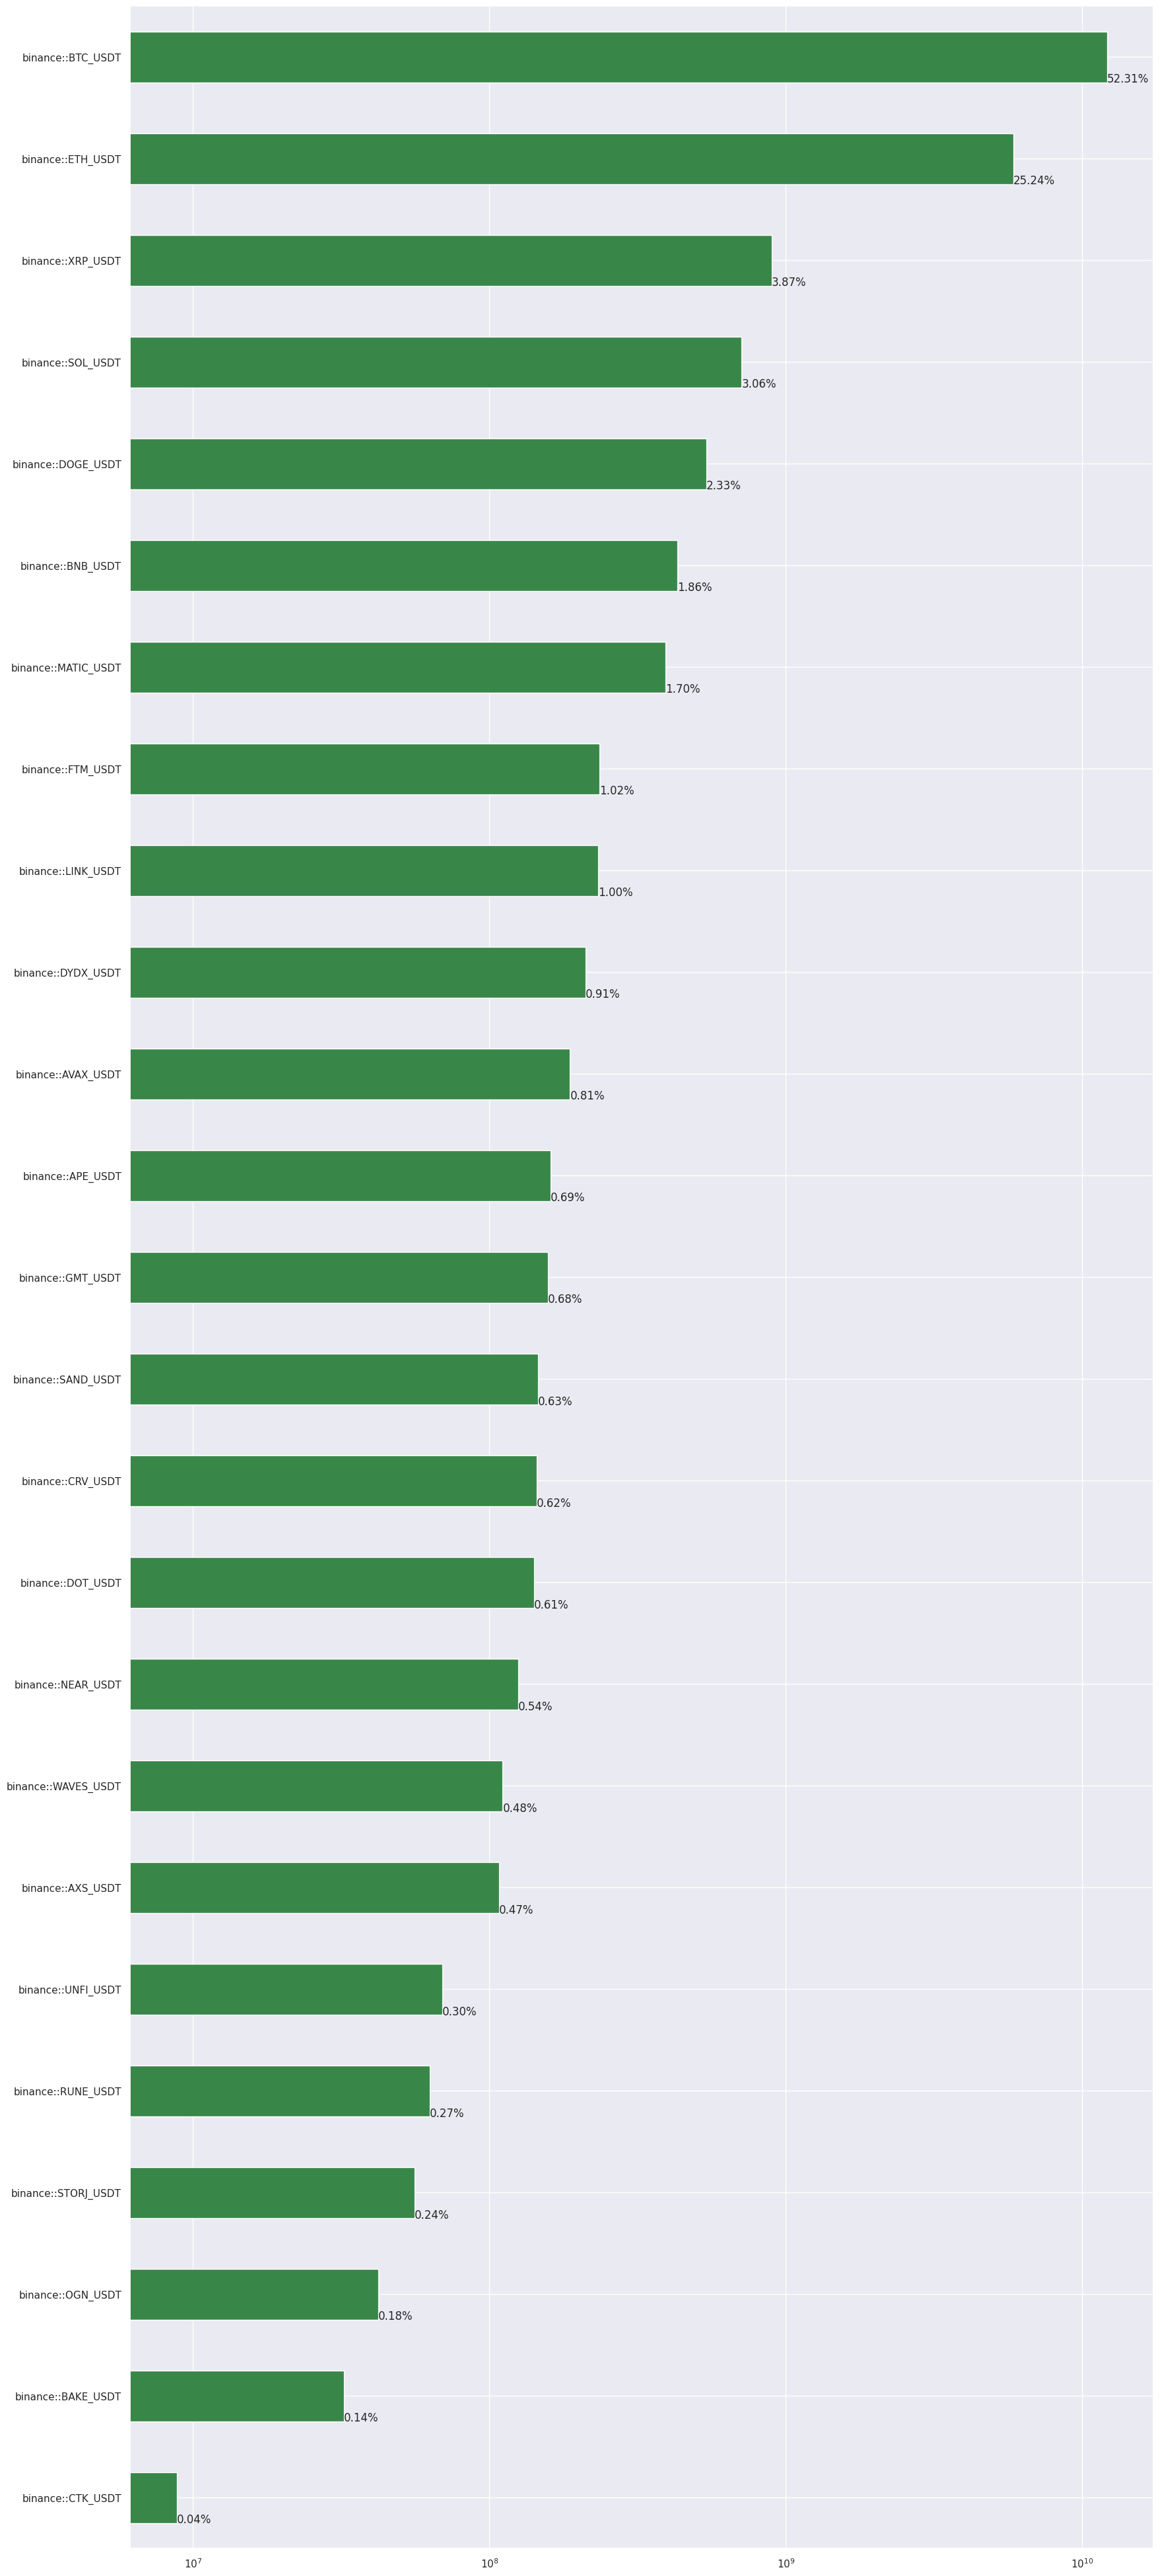

In [11]:
coplotti.plot_barplot(
    mdv_notional,
    annotation_mode="pct",
    orientation="horizontal",
    figsize=[20, 50],
    yscale="log",
)

# Bid / ask price changes

In [12]:
# TODO(Grisha): use `ImClient` once bid/ask data is resampled to 1 minute.
bid_ask_reader = icdc.RawDataReader(
    config["bid_ask_data"]["signature"],
    stage=config["bid_ask_data"]["db_stage"],
)
bid_ask_data = bid_ask_reader.read_data(
    config["bid_ask_data"]["start_timestamp"],
    config["bid_ask_data"]["end_timestamp"],
)
_LOG.info("bid_ask_data.shape=%s", bid_ask_data.shape)
hpandas.df_to_str(bid_ask_data, num_rows=5, log_level=logging.INFO)

INFO  Loading dataset schema file: /app/amp/data_schema/dataset_schema_versions/dataset_schema_v3.json
INFO  Loaded dataset schema version v3
INFO  Loading dataset schema file: /app/amp/data_schema/dataset_schema_versions/dataset_schema_v3.json
INFO  Loaded dataset schema version v3
INFO  Loading dataset schema file: /app/amp/data_schema/dataset_schema_versions/dataset_schema_v3.json
INFO  Loaded dataset schema version v3
INFO  bid_ask_data.shape=(3694300, 13)


,timestamp,bid_size,bid_price,ask_size,ask_price,exchange_id,level,end_download_timestamp,knowledge_timestamp,currency_pair,year,month,day
2023-09-10 15:04:28.116000+00:00,1694358268116,14099.0,1.248,76838.0,1.249,binance,1,2023-09-10 15:04:28.309770+00:00,2023-09-10 15:04:29.536731+00:00,APE_USDT,2023,9,10
2023-09-10 15:04:28.116000+00:00,1694358268116,68312.0,1.247,41656.0,1.25,binance,2,2023-09-10 15:04:28.309770+00:00,2023-09-10 15:04:29.536731+00:00,APE_USDT,2023,9,10
,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-10 15:00:20.492000+00:00,1694358020492,231376.6,0.4961,178965.7,0.4978,binance,9,2023-09-10 15:00:20.701573+00:00,2023-09-10 15:00:21.122542+00:00,XRP_USDT,2023,9,10
2023-09-10 15:00:20.492000+00:00,1694358020492,583520.4,0.496,188081.9,0.4979,binance,10,2023-09-10 15:00:20.701573+00:00,2023-09-10 15:00:21.122542+00:00,XRP_USDT,2023,9,10


In [13]:
# Keep only the top-of-the-book data for further analysis.
bid_ask_data = bid_ask_data[bid_ask_data["level"] == 1]
bid_ask_data.head()

,timestamp,bid_size,bid_price,ask_size,ask_price,exchange_id,level,end_download_timestamp,knowledge_timestamp,currency_pair,year,month,day
timestamp,,,,,,,,,,,,,
2023-09-10 15:04:28.116000+00:00,1694358268116,14099.0,1.248,76838.0,1.249,binance,1,2023-09-10 15:04:28.309770+00:00,2023-09-10 15:04:29.536731+00:00,APE_USDT,2023,9,10
2023-09-10 15:04:28.362000+00:00,1694358268362,14099.0,1.248,76878.0,1.249,binance,1,2023-09-10 15:04:28.510515+00:00,2023-09-10 15:04:29.536731+00:00,APE_USDT,2023,9,10
2023-09-10 15:04:28.465000+00:00,1694358268465,13684.0,1.248,76686.0,1.249,binance,1,2023-09-10 15:04:28.711365+00:00,2023-09-10 15:04:29.536731+00:00,APE_USDT,2023,9,10
2023-09-10 15:04:28.723000+00:00,1694358268723,16093.0,1.248,76661.0,1.249,binance,1,2023-09-10 15:04:28.912138+00:00,2023-09-10 15:04:29.536731+00:00,APE_USDT,2023,9,10
2023-09-10 15:04:28.831000+00:00,1694358268831,16093.0,1.248,76545.0,1.249,binance,1,2023-09-10 15:04:29.113207+00:00,2023-09-10 15:04:29.536731+00:00,APE_USDT,2023,9,10


In [14]:
full_symbol_col = ivcu.build_full_symbol(
    bid_ask_data["exchange_id"], bid_ask_data["currency_pair"]
)
bid_ask_data.insert(
    0, config["column_names"]["full_symbol_column"], full_symbol_col
)
bid_ask_data.head(3)

,full_symbol,timestamp,bid_size,bid_price,ask_size,ask_price,exchange_id,level,end_download_timestamp,knowledge_timestamp,currency_pair,year,month,day
timestamp,,,,,,,,,,,,,,
2023-09-10 15:04:28.116000+00:00,binance::APE_USDT,1694358268116,14099.0,1.248,76838.0,1.249,binance,1,2023-09-10 15:04:28.309770+00:00,2023-09-10 15:04:29.536731+00:00,APE_USDT,2023,9,10
2023-09-10 15:04:28.362000+00:00,binance::APE_USDT,1694358268362,14099.0,1.248,76878.0,1.249,binance,1,2023-09-10 15:04:28.510515+00:00,2023-09-10 15:04:29.536731+00:00,APE_USDT,2023,9,10
2023-09-10 15:04:28.465000+00:00,binance::APE_USDT,1694358268465,13684.0,1.248,76686.0,1.249,binance,1,2023-09-10 15:04:28.711365+00:00,2023-09-10 15:04:29.536731+00:00,APE_USDT,2023,9,10


In [15]:
# Remove `timestamp` column since the info is already in index.
bid_ask_data = bid_ask_data.drop(config["column_names"]["timestamp"], axis=1)
bid_ask_data = (
    bid_ask_data.reset_index()
    .sort_values(
        [
            config["column_names"]["full_symbol_column"],
            config["column_names"]["timestamp"],
        ]
    )
    .set_index(config["column_names"]["timestamp"])
)
bid_ask_data = bid_ask_data.sort_index()
bid_ask_data.head(3)

,full_symbol,bid_size,bid_price,ask_size,ask_price,exchange_id,level,end_download_timestamp,knowledge_timestamp,currency_pair,year,month,day
timestamp,,,,,,,,,,,,,
2023-09-10 15:00:00.003000+00:00,binance::APE_USDT,38370.0,1.2540,19451.0,1.2550,binance,1,2023-09-10 15:00:00.217196+00:00,2023-09-10 15:00:01.050541+00:00,APE_USDT,2023,9,10
2023-09-10 15:00:00.007000+00:00,binance::SAND_USDT,34489.0,0.2939,3833.0,0.2940,binance,1,2023-09-10 15:00:00.216211+00:00,2023-09-10 15:00:01.050541+00:00,SAND_USDT,2023,9,10
2023-09-10 15:00:00.010000+00:00,binance::OGN_USDT,208831.0,0.0888,218202.0,0.0889,binance,1,2023-09-10 15:00:00.222327+00:00,2023-09-10 15:00:01.050541+00:00,OGN_USDT,2023,9,10


In [16]:
# Remove duplicates.
use_index = True
duplicate_columns = [config["column_names"]["full_symbol_column"]]
_LOG.info(
    "The number of rows before removing duplicates=%s", bid_ask_data.shape[0]
)
bid_ask_data = hpandas.drop_duplicates(
    bid_ask_data,
    column_subset=duplicate_columns,
    use_index=use_index,
)
_LOG.info(
    "The number of rows after removing duplicates=%s", bid_ask_data.shape[0]
)

INFO  The number of rows before removing duplicates=369430
INFO  The number of rows after removing duplicates=329827


In [17]:
# Check whether the bid price has changed or not.
bid_ask_data["is_bid_price_changed"] = (
    bid_ask_data.groupby(config["column_names"]["full_symbol_column"])[
        "bid_price"
    ]
    .diff()
    .abs()
    > 0
)
# Check whether the ask price has changed or not.
bid_ask_data["is_ask_price_changed"] = (
    bid_ask_data.groupby(config["column_names"]["full_symbol_column"])[
        "ask_price"
    ]
    .diff()
    .abs()
    > 0
)
# The price has changed if either bid or ask price has changed.
bid_ask_data["is_price_changed"] = (
    bid_ask_data["is_bid_price_changed"] | bid_ask_data["is_ask_price_changed"]
)
bid_ask_data.head()

,full_symbol,bid_size,bid_price,ask_size,ask_price,exchange_id,level,end_download_timestamp,knowledge_timestamp,currency_pair,year,month,day,is_bid_price_changed,is_ask_price_changed,is_price_changed
timestamp,,,,,,,,,,,,,,,,
2023-09-10 15:00:00.003000+00:00,binance::APE_USDT,38370.0,1.25400,19451.0,1.25500,binance,1,2023-09-10 15:00:00.217196+00:00,2023-09-10 15:00:01.050541+00:00,APE_USDT,2023,9,10,False,False,False
2023-09-10 15:00:00.007000+00:00,binance::SAND_USDT,34489.0,0.29390,3833.0,0.29400,binance,1,2023-09-10 15:00:00.216211+00:00,2023-09-10 15:00:01.050541+00:00,SAND_USDT,2023,9,10,False,False,False
2023-09-10 15:00:00.010000+00:00,binance::OGN_USDT,208831.0,0.08880,218202.0,0.08890,binance,1,2023-09-10 15:00:00.222327+00:00,2023-09-10 15:00:01.050541+00:00,OGN_USDT,2023,9,10,False,False,False
2023-09-10 15:00:00.012000+00:00,binance::MATIC_USDT,42464.0,0.52110,20136.0,0.52120,binance,1,2023-09-10 15:00:00.217365+00:00,2023-09-10 15:00:01.050541+00:00,MATIC_USDT,2023,9,10,False,False,False
2023-09-10 15:00:00.014000+00:00,binance::DOGE_USDT,1101478.0,0.06136,73602.0,0.06137,binance,1,2023-09-10 15:00:00.222510+00:00,2023-09-10 15:00:01.050541+00:00,DOGE_USDT,2023,9,10,False,False,False


In [18]:
# Count the number of times when the price has changed within a bar.
price_changes_count = (
    bid_ask_data.groupby(config["column_names"]["full_symbol_column"])
    .resample(config["bar_duration"])["is_price_changed"]
    .sum()
    .reset_index()
)
# Rename column accordingly.
price_changes_count = price_changes_count.rename(
    columns={"is_price_changed": "price_changes_amount"}
)
price_changes_count.head()

,full_symbol,timestamp,price_changes_amount
0,binance::APE_USDT,2023-09-10 15:00:00+00:00,149
1,binance::APE_USDT,2023-09-10 15:05:00+00:00,40
2,binance::APE_USDT,2023-09-10 15:10:00+00:00,21
3,binance::APE_USDT,2023-09-10 15:15:00+00:00,13
4,binance::APE_USDT,2023-09-10 15:20:00+00:00,3


In [19]:
# Average price change counts across all bars.
avg_price_changes_5T = (
    price_changes_count.groupby(config["column_names"]["full_symbol_column"])[
        "price_changes_amount"
    ]
    .mean()
    .sort_values()
    .round(2)
)
avg_price_changes_5T

full_symbol
binance::CRV_USDT        8.83
binance::BAKE_USDT      13.67
binance::NEAR_USDT      14.50
binance::OGN_USDT       16.83
binance::RUNE_USDT      20.58
binance::APE_USDT       24.67
binance::GMT_USDT       25.33
binance::FTM_USDT       32.92
binance::DYDX_USDT      39.17
binance::XRP_USDT       46.33
binance::SAND_USDT      47.17
binance::DOT_USDT       51.58
binance::BNB_USDT       64.00
binance::AXS_USDT       68.50
binance::LINK_USDT      73.92
binance::DOGE_USDT      75.33
binance::MATIC_USDT     77.92
binance::BTC_USDT       81.08
binance::CTK_USDT      101.25
binance::AVAX_USDT     110.08
binance::ETH_USDT      131.33
binance::UNFI_USDT     158.08
binance::WAVES_USDT    215.42
binance::STORJ_USDT    333.75
binance::SOL_USDT      337.00
Name: price_changes_amount, dtype: float64

# ECDF

In [20]:
# There are 2 asset_ids in the current universe that are not in the ECDF series.
ecdf = pd.Series(
    index=[
        2484635488,
        1966583502,
        1030828978,
        1528092593,
        6051632686,
        2425308589,
        2099673105,
        4516629366,
        3401245610,
        1891737434,
        2540896331,
        5118394986,
        3065029174,
        2683705052,
        5115052901,
        2601760471,
        8717633868,
        8968126878,
        2237530510,
        2384892553,
        1467591036,
        1464553467,
        1776791608,
    ],
    data=[
        0.008451,
        0.014953,
        0.015789,
        0.025316,
        0.027273,
        0.036446,
        0.040000,
        0.081967,
        0.087719,
        0.127178,
        0.127451,
        0.176252,
        0.181070,
        0.215501,
        0.217923,
        0.284585,
        0.326877,
        0.394872,
        0.510309,
        0.512681,
        0.552356,
        0.555556,
        0.720000,
    ],
)

In [21]:
ecdf.index = [asset_id_to_full_symbol_mapping[idx] for idx in ecdf.index]
ecdf = ecdf.sort_values()
ecdf.name = "ecdf"
ecdf

binance::OGN_USDT      0.008451
binance::FTM_USDT      0.014953
binance::GMT_USDT      0.015789
binance::BAKE_USDT     0.025316
binance::APE_USDT      0.027273
binance::STORJ_USDT    0.036446
binance::RUNE_USDT     0.040000
binance::SAND_USDT     0.081967
binance::DYDX_USDT     0.087719
binance::DOT_USDT      0.127178
binance::AXS_USDT      0.127451
binance::XRP_USDT      0.176252
binance::DOGE_USDT     0.181070
binance::MATIC_USDT    0.215501
binance::CTK_USDT      0.217923
binance::LINK_USDT     0.284585
binance::AVAX_USDT     0.326877
binance::BNB_USDT      0.394872
binance::SOL_USDT      0.510309
binance::WAVES_USDT    0.512681
binance::BTC_USDT      0.552356
binance::ETH_USDT      0.555556
binance::UNFI_USDT     0.720000
Name: ecdf, dtype: float64

# Compute rank correlation

In [22]:
liquidity_metrics_df = pd.concat(
    [avg_price_changes_5T, mdv_notional, ecdf],
    axis=1,
)
liquidity_metrics_df

,price_changes_amount,mdv_notional,ecdf
binance::CRV_USDT,8.83,1.444697e+08,NaN
binance::BAKE_USDT,13.67,3.228727e+07,0.025316
binance::NEAR_USDT,14.50,1.252604e+08,NaN
binance::OGN_USDT,16.83,4.206300e+07,0.008451
binance::RUNE_USDT,20.58,6.277072e+07,0.040000
binance::APE_USDT,24.67,1.604041e+08,0.027273
binance::GMT_USDT,25.33,1.573858e+08,0.015789
binance::FTM_USDT,32.92,2.351366e+08,0.014953
binance::DYDX_USDT,39.17,2.108924e+08,0.087719
binance::XRP_USDT,46.33,8.967219e+08,0.176252


In [23]:
is_price_changed_rank = liquidity_metrics_df["price_changes_amount"].rank()
mdv_notional_rank = liquidity_metrics_df["mdv_notional"].rank()
ecdf_rank = liquidity_metrics_df["ecdf"].rank()

In [24]:
rank_df = pd.concat(
    [is_price_changed_rank, mdv_notional_rank, ecdf_rank],
    axis=1,
)
rank_df

,price_changes_amount,mdv_notional,ecdf
binance::CRV_USDT,1.0,11.0,NaN
binance::BAKE_USDT,2.0,2.0,4.0
binance::NEAR_USDT,3.0,9.0,NaN
binance::OGN_USDT,4.0,3.0,1.0
binance::RUNE_USDT,5.0,5.0,7.0
binance::APE_USDT,6.0,14.0,5.0
binance::GMT_USDT,7.0,13.0,3.0
binance::FTM_USDT,8.0,18.0,2.0
binance::DYDX_USDT,9.0,16.0,9.0
binance::XRP_USDT,10.0,23.0,12.0


In [25]:
corr_matrix_spearman = rank_df.corr(method="spearman")
corr_matrix_spearman

,price_changes_amount,mdv_notional,ecdf
price_changes_amount,1.000000,0.235385,0.777668
mdv_notional,0.235385,1.000000,0.432806
ecdf,0.777668,0.432806,1.000000


In [26]:
corr_matrix_kendall = rank_df.corr(method="kendall")
corr_matrix_kendall

,price_changes_amount,mdv_notional,ecdf
price_changes_amount,1.000000,0.193333,0.628458
mdv_notional,0.193333,1.000000,0.312253
ecdf,0.628458,0.312253,1.000000
